# Attribution Methods for Hyperspectral Image Analysis using `attr`

This notebook showcases attribution methods from `meteors.attr` to interpret predictions from a hyperspectral image regression model using KP Labs and European Space Agency (ESA)'s [HYPERVIEW Challenge](https://platform.ai4eo.eu/seeing-beyond-the-visible-permanent) dataset, which predicts `4`soil parameters from airborne hyperspectral images.


The model used in this notebook is one of the top-performing models in the challenge. The trained model architecture is based on the Vision Transformer (ViT) and CLIP (Contrastive Language-Image Pretraining), and its fine-tuned weights are open-sourced under the Apache License in the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). In the same place, the original implementation of the CLIP model can be found. 

**Prerequisites**: Install the meteors package from PyPI:

```bash
pip install meteors
```

which includes required dependencies. The `clip_model` module contains the code needed for additional preprocessing and model loading, and can be downloaded from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/hyperview_challenge).

## Table of Contents
- [1. Loading the Model and Hyperspectral data](#1-loading-the-model)
- [2. Convert data into HSI image and preview the images](#3-convert-data-into-hsi-image-and-preview-the-images)
- [3. Analyze HSI data with Attribution Algorithms](#3-analyze-hsi-data-with-attribution-algorithms)
  - [3.1. Gradient Based Methods](#31-gradient-based-methods)
  - [3.2. Occlusion Based Methods](#32-occlusion-based-methods)
  - [3.3. Perturbation Based Methods](#33-perturbation-based-methods)

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

import meteors as mt

from clip_utils import load_base_clip, download

# Always try to set the seed for repeatability :)
torch.manual_seed(0)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Loading the Model and Hyperspectral data

The dataset used for training this model can be found on the official page for the [HYPERVIEW Challenge](https://platform.ai4eo.eu/seeing-beyond-the-visible-permanent).

In the cell below, we load the model.

In [3]:
download_root = os.path.expanduser("~/.cache/clip")
num_classes = 4

Load the CLIP model with the HYPERVIEW head

In [4]:
model = load_base_clip(download_root=download_root, class_num=num_classes)

Load the pre-trained weights

In [5]:
vit_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt",
    download_root,
    error_checksum=False,
)
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
model = model.to(device)

And the hyperspectral data.

In [6]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    padded = np.pad(
        data,
        ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),
        "constant",
        constant_values=0.0,
    )
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask


def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            transforms.Resize((image_shape, image_shape)),
        ]
    )

In [7]:
data, mask = load_single_npz_image("data/0.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(masked_data)
not_masked_image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

print(f"Original data shape: {data.shape}")
print(f"Original mask shape: {mask.shape}")
print(f"Transformed data shape: {image_torch.shape}")

Original data shape: (89, 89, 150)
Original mask shape: (89, 89, 150)
Transformed data shape: torch.Size([150, 224, 224])


As specified in the HYPERVIEW Challenge dataset description, we will also utilize the information about bands' wavelengths.


In [8]:
with open("data/wavelenghts.txt", "r") as f:
    wavelengths = f.readline()
wavelengths = [float(wave.strip()) for wave in wavelengths.split(",")]

## 2. Convert data into HSI image and preview the images
Now, having the raw data - the tensor representing the image, its wavelengths and the image orientation, we can to combine this information into a complete hyperspectral image. To create the hyperspectral image, we will use the `HSI` data class from the `meteors` package.

From now on, we will use the `HSI` class to represent the hyperspectral image. The `HSI` class provides a set of methods to work with hyperspectral images, including visualization.

Additionally, we may provide the binary mask, which may cover data irrelevant for the task, as suggested by the challenge dataset providers. Thus, We create a binary mask from the image, where 1 is the masked region and 0 is the unmasked region.

In [9]:
binary_mask = (image_torch > 0.0).int()

The HSI object has the following attributes:

- `data` - the preprocessed hyperspectral image data in numpy or pytorch with the shape (bands, height, width)
- `wavelengths` - the wavelengths list of the hyperspectral image
- `orientation` - the orientation of the image, here it is `CWH` (Channels, Width, Height)
- `binary_mask` - the binary mask of the image
- `device` - the device where the image data will be stored. We can provide it later with the `.to(device)` method

In [10]:
hsi_0 = mt.HSI(
    image=not_masked_image_torch,
    wavelengths=wavelengths,
    orientation="CWH",
    binary_mask=binary_mask,
    device=device,
)

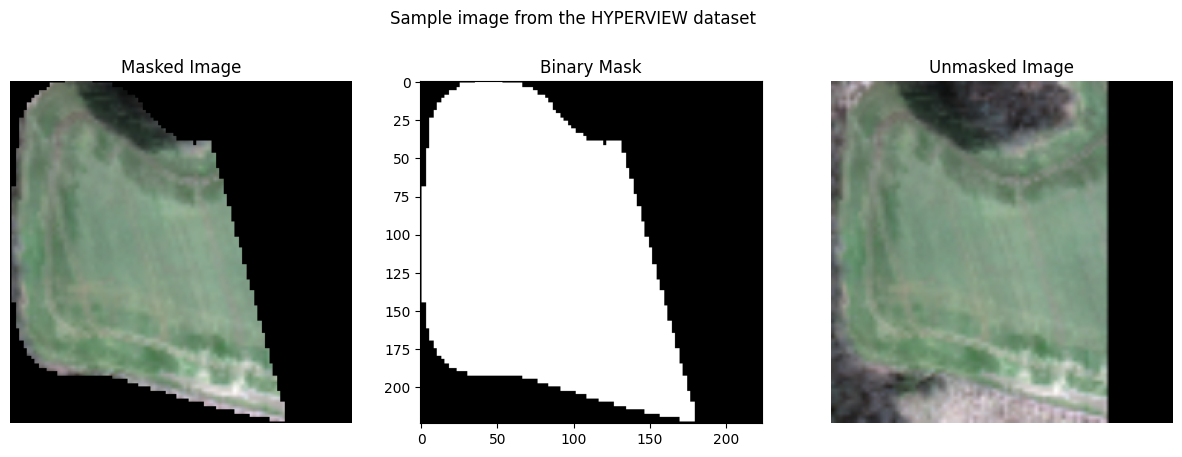

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mt.visualize.visualize_hsi(hsi_0, ax1, use_mask=True)
ax1.set_title("Masked Image")

ax2.imshow(binary_mask[0, ...].T.cpu().numpy(), cmap="gray")
ax2.set_title("Binary Mask")

mt.visualize.visualize_hsi(hsi_0, ax3, use_mask=False)
ax3.set_title("Unmasked Image")

fig.suptitle("Sample image from the HYPERVIEW dataset")
plt.show()

In the left image, we see the input RGB representation of the data, in the middle: the mask of the hyperspectral image, and in the right: the whole area captured within this hyperspectral image (without any mask).

The `HSI` dataclass automatically provides the clean RGB image corresponding to the hyperspectral image, and releases us from the obligation of selecting the specific wavelengths to be plotted, and considering the image orientation or processing.

Now, we can provide the hyperspectral image to the model and get the prediction. The model will return the predictions for the 4 classes of soil parameters which should be estimated based on the provided hyperspectral image.

In [12]:
original_prediction = model(not_masked_image_torch.unsqueeze(0))
hsi_prediction = model(hsi_0.image.unsqueeze(0))
assert torch.allclose(original_prediction, hsi_prediction, atol=1e-3)

The soil parameters that are included in the HYPERVIEW dataset encompass:

In [13]:
prediction_dict = {0: "Phosphorus", 1: "Potassium", 2: "Magnesium", 3: "pH"}

In [14]:
predictions = {prediction_dict[i]: float(hsi_prediction[0, i].cpu().detach().numpy()) for i in range(4)}
predictions = pd.Series(predictions)
predictions

Phosphorus    0.210551
Potassium     0.350670
Magnesium     0.391935
pH            0.883228
dtype: float64

## 3. Analyze HSI data with Attribution Algorithms

The `Meteors` package provides several attribution algorithms grouped into three categories (if you want to learn more about each technique, just click the method and it will redirect you to the documentation):

- **Gradient Based**: [`Saliency`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.saliency.Saliency), [`InputXGradient`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.input_x_gradients.InputXGradient), [`IntegratedGradients`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.integrated_gradients.IntegratedGradients)
- **Occlusion Based**: [`Occlusion`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.occlusion.Occlusion)
- **Perturbation Based**: [`NoiseTunnel`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.noise_tunnel.NoiseTunnel), [`HyperNoiseTunnel`](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.noise_tunnel.HyperNoiseTunnel)

Let's explore how these methods help interpret our hyperspectral image model's predictions.

**Note** Each attribution method in this tutorial can only analyze one class at a time for multi-target models. We'll focus on analyzing the `P` class (index 0) in our examples, though similar analyses could be performed for other classes.

Before we start, let's prepare our model for the interpretation task by wrapping it with the `meteors` helper class.

In [15]:
explainable_model = mt.models.ExplainableModel(model, "regression")

### 3.1. Gradient Based Methods

Gradient-based attribution methods compute the importance of each input feature by analyzing the model's gradients with respect to the input. These methods are computationally efficient and provide insights into how the model's predictions change with small input variations.

#### Saliency
Simple yet effective method that computes the gradient of the output with respect to the input. The magnitude of these gradients indicates which input features most strongly influence the prediction.

[Captum Documentation](https://captum.ai/api/saliency.html)

Paper: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)

#### InputXGradient
An extension of Saliency that multiplies the input by its gradient. This helps reduce noise in the attribution maps and better highlights relevant features by accounting for both feature values and their gradients.

[Captum Documentation](https://captum.ai/api/input_x_gradient.html)

Paper: [Not Just a Black Box: Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1605.01713)

#### IntegratedGradients
More sophisticated approach that accumulates gradients along a path from a baseline to the input. This method addresses the gradient saturation problem found in simpler approaches. It works by performing the following steps:

1. Accumulate gradients along a straight-line path from a baseline (usually zero) to the input
2. Compute an integral of gradients to capture the cumulative feature importance
3. Use multiple interpolated steps between baseline and input for better approximation
4. Satisfy important theoretical properties like completeness (attributions sum to the difference between output and baseline)

[Captum Documentation](https://captum.ai/api/integrated_gradients.html)

Paper: [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)


In [16]:
saliency = mt.attr.Saliency(explainable_model)
inputxgrad = mt.attr.InputXGradient(explainable_model)
ig = mt.attr.IntegratedGradients(explainable_model)

To use these methods, we need to just call the `attribute` method on the interpreter model with this arguments (more details in the documentation):

- `hsi` - the hyperspectral image data
- `target` - the target index class to be analyzed: 0 for `P` (Phosphorus) class

and to visualize the results, we can use one of the visualization methods provided by the `meteors` package.

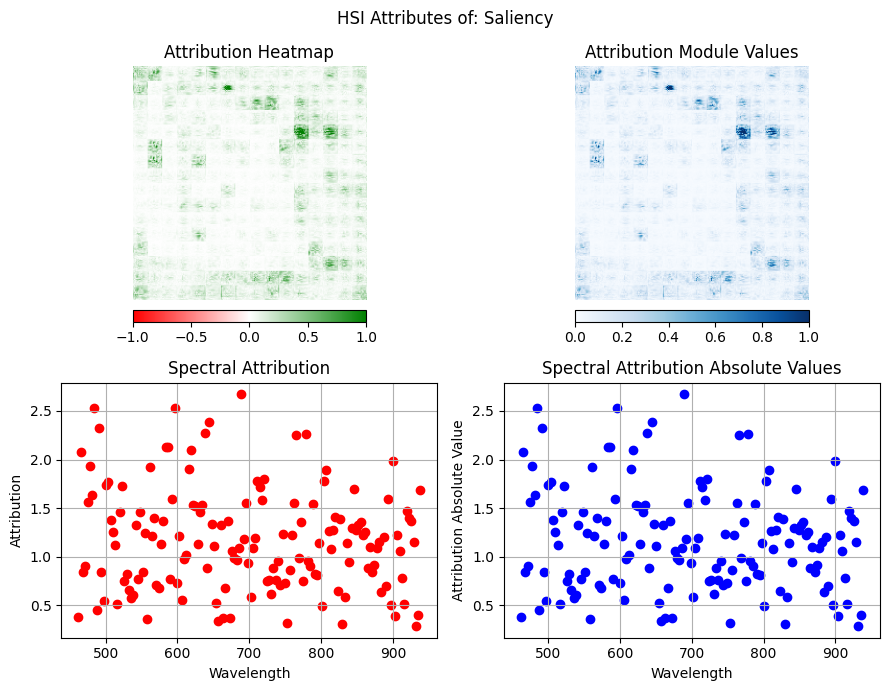

CPU times: user 9.57 s, sys: 1.35 s, total: 10.9 s
Wall time: 2.18 s


In [17]:
%%time
saliency_attr = saliency.attribute(
    hsi_0,
    target=0,  # Class index to be analized
)
mt.visualize.visualize_attributes(saliency_attr, use_pyplot=True)

The plots that we use to visualize our attributions are created from `visualize`. The `visualize_attributes` function visualizes the attribution with two spatial plots on top and two spectral plots below. The spatial plots present correlation of the spatial pixels with the output. If the correlation is negative (red), it means that this pixel lowered the model estimation for class `P`; if positive (green), it increased the prediction; and if around zero (white), then it was not impactful. In the lower plots, we see attributions aggregated per wavelength, showcasing how each wavelength correlated with the output - once again, negative values lowered, positive ones increased, and values close to zero were not impactful. These attributions are aggregated spatially and spectrally with mean over spatial or spectral axis.

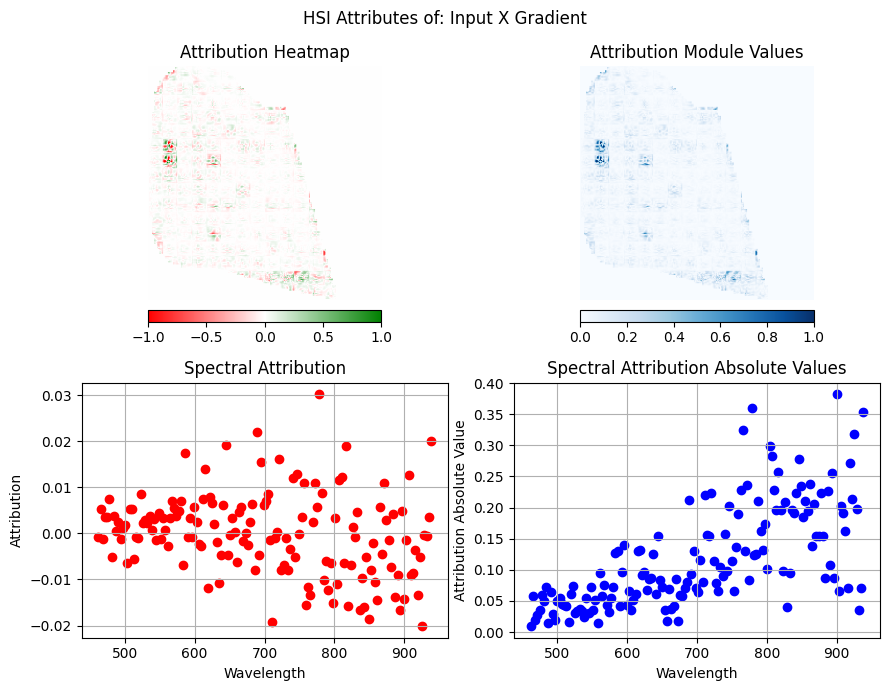

CPU times: user 9.5 s, sys: 1.35 s, total: 10.9 s
Wall time: 2.18 s


In [18]:
%%time
inputxgrad_attr = inputxgrad.attribute(hsi_0, target=0)
mt.visualize.visualize_attributes(inputxgrad_attr, use_pyplot=True)

For the `IntegratedGradients` method, we may also provide:

- `return_convergence_delta` - if set to `True`, the method will return the convergence delta, which is the difference between the approximated integral and the true integral. This can be useful to assess the quality of the approximation. The value of the delta is stored in `score` attribute of the `Attribution` object.
- `n_steps` - the number of steps to approximate the integral - more steps will likely yield better results but will also take longer to compute.

Convergence Delta: 0.0011369975069135917


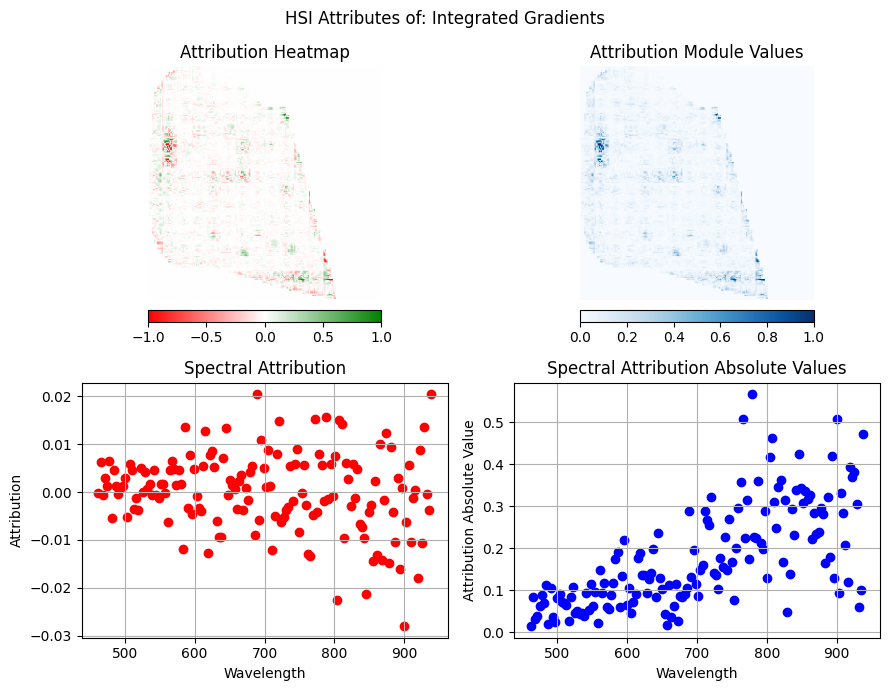

CPU times: user 6min 51s, sys: 2min 36s, total: 9min 27s
Wall time: 1min 59s


In [19]:
%%time
ig_attr = ig.attribute(
    hsi_0,
    target=0,
    baseline=0.0,
    return_convergence_delta=True,
    n_steps=50,
)
print(f"Convergence Delta: {ig_attr.score}")
mt.visualize.visualize_attributes(ig_attr, use_pyplot=True)

Each method calculates feature importance on a per-pixel basis, which can be visualized across both spatial and spectral domains. Our analysis of the three methods revealed distinct characteristics.

The saliency method, while computationally fastest, produced noisy attributions and incorrectly highlighted importance in masked (zero-value) regions.

The input × gradient method offered clearer results with well-defined importance regions. It performed comparably to integrated gradients but with significantly faster computation time. The integrated gradients method, though computationally intensive, typically provided the most precise attributions. However, in this particular case, its results were not substantially better than those from the input × gradient method. Its computation time can be adjusted through the number of integration steps, offering flexibility in balancing attribution quality against processing speed.

Additionaly methods that return the attributions for spatial **AND** spectral dimensions can be visualized spatial for specific bands or wavelengths. For example in case Integtared Gradients we can see that the *900* wavelenght is the most negativly impactful for the model prediction, so lets visualize the attributions spatialy to see where the model is focusing on this wavelenght.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

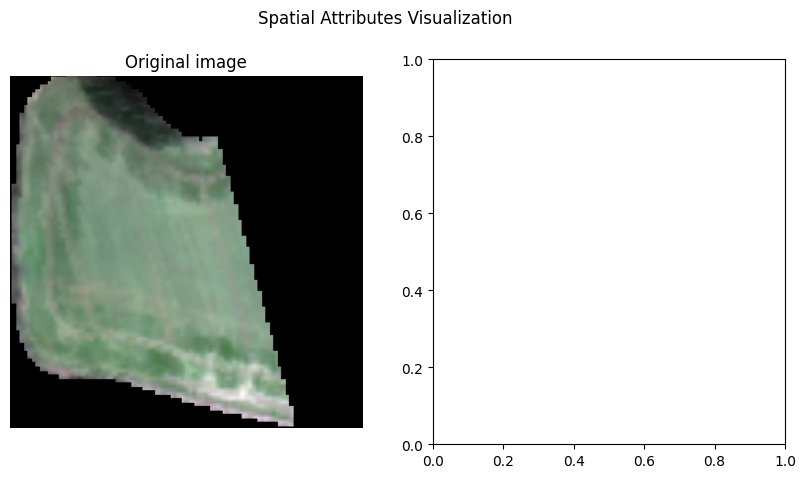

In [20]:
mt.visualize.visualize_bands_spatial_attributes(ig_attr, spectral_wavelengths=[900.01], use_pyplot=True)

### 3.2. Occlusion Based Methods

Occlusion-based methods offer an intuitive approach to understanding model predictions by systematically blocking (occluding) portions of the input and observing how the model's output changes. Unlike gradient methods, these techniques don't require access to model gradients, making them applicable to any model architecture.

#### Occlusion
This method works by performing the following steps:

1. Slide a mask (window) across the input image
2. Set the masked region to a baseline value (typically zero or mean)
3. Measure the difference in model output between original and occluded inputs 
4. Create an attribution map where higher values indicate regions whose occlusion significantly impacts the prediction

[Captum Documentation](https://captum.ai/api/occlusion.html)

Paper: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)

For hyperspectral images, occlusion can be performed along the spectral dimension (blocking individual bands) or spatially (masking image regions).

In [20]:
occlusion = mt.attr.Occlusion(explainable_model)

occlusion method can be used with the following arguments:

- `hsi` - the hyperspectral image data
- `target` - the target index class to be analyzed: 0 for `P` (Phosphorus) class
- `baseline` - the baseline value to replace the occluded region. It should be a float value.
- `sliding_window_shapes` - the shape of the sliding window to occlude the image. It should be a tuple of three integers 3D occlusion.
- `strides` - the strides of the sliding window. It should be a tuple of three integers 3D occlusion.

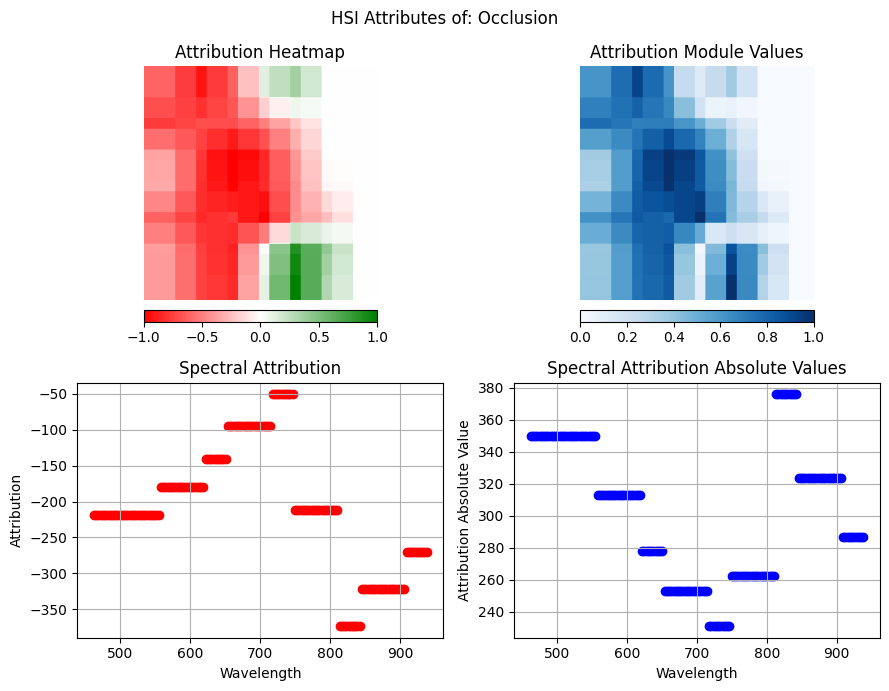

CPU times: user 25min 12s, sys: 1min 45s, total: 26min 57s
Wall time: 7min 6s


In [21]:
%%time
occlusion_attr = occlusion.attribute(
    hsi_0,
    target=0,
    baseline=0.0,
    sliding_window_shapes=(50, 50, 50),
    strides=(30, 30, 30),
)
mt.visualize.visualize_attributes(occlusion_attr, use_pyplot=True)

The visualizations are similar to those from gradient-based methods; however, the granularity of the attributions is much smaller. This is due to the `sliding_window_shapes` and `strides` parameters. If we specified smaller `sliding_window_shapes`, we would get more granular attributions, and depending on the mask step (`strides`), we could also cover more or less pixels. The most important considerations when choosing the `strides` and `sliding_window_shapes` are that `strides` should not be bigger than `sliding_window_shapes`, as it is beneficial for masks to overlap minimally in every step. Additionally, we should start first with the large mask, as decreasing the mask size requires more steps to obtain the attributions, which means longer computation time.

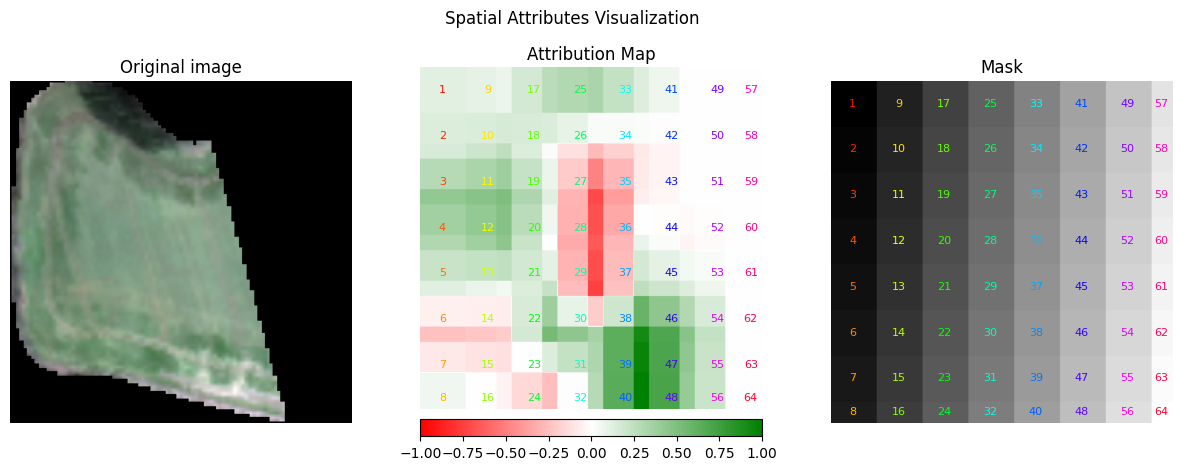

CPU times: user 4min 44s, sys: 19.1 s, total: 5min 3s
Wall time: 59.1 s


In [22]:
%%time
occlusion_spatial_attr = occlusion.get_spatial_attributes(
    hsi_0, target=0, baseline=0.0, sliding_window_shapes=(50, 50), strides=(30, 30)
)
mt.visualize.visualize_spatial_attributes(occlusion_spatial_attr, use_pyplot=True)

The `Occlusion` method also allows us to calculate the mask only for spatial dimensions rather than for every pixel. The parameters remain the same, but notice that we set a 2D shape instead of a 3D shape. We don't need to pass 3D `sliding_window_shapes` and `strides` because for the spatial axes we set the shape automatically to the maximum. This means that the mask and the step will always cover all spectral pixels in the given spatial context, allowing for more specific spatial analysis.

The visualization process is similar to the one presented before, but now uses the `visualize_spatial_attributes` function, which produces three components: the original image on the left, an attribution map in the center (where colors and values represent the correlation with the output class), and a mask visualization on the right. Note that the displayed mask is just a simple version how mask behaves, as the `strides` is not larger than the mask size. In practice, the masks should always overlap, but for visualization simplicity, we assumed non-overlapping masks.

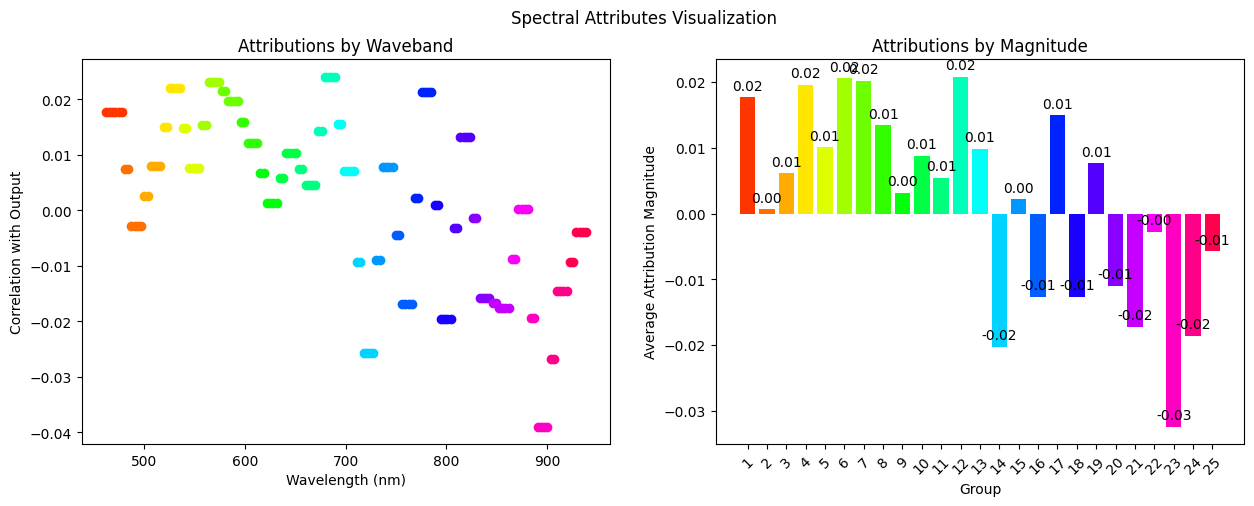

CPU times: user 2min 16s, sys: 8.48 s, total: 2min 25s
Wall time: 25.2 s


In [23]:
%%time
occlusion_spectral_attr = occlusion.get_spectral_attributes(
    hsi_0, target=0, baseline=0.0, sliding_window_shapes=(8), strides=(6)
)
mt.visualize.visualize_spectral_attributes(occlusion_spectral_attr, use_pyplot=True)

Just as we can perform analysis in the spatial context, we can also analyze the spectral dimension. For spectral analysis, we specify only one-dimensional shapes for `sliding_window_shapes` and `strides`, as the mask will cover all spatial pixels for each spectral position. The `visualize_spectral_attributes` function presents two plots: the left plot shows the attribution scores for each wavelength, colored by mask ID, while the right plot uses the same color coding but displays the attributions as a bar plot, with groups on the x-axis to better compare contributions across different mask IDs.

The occlusion method provides visualizations similar to gradient-based approaches but offers more granular control over spectral and spatial analysis. By selectively occluding regions, we can analyze either entire spatial or spectral regions independently. Although our results appear blurry due to large occlusion regions, they reveal clear patterns: spatial occlusion shows higher importance in non-masked regions as expected, while spectral analysis indicates that lower wavelengths have more positive importance and higher wavelengths have more negative importance. While the precision of results can be improved by using smaller occlusion regions, this comes at the cost of increased computation time.

### 3.3. Perturbation Based Methods

Perturbation-based methods analyze model behavior by introducing controlled noise or variations to the input. These methods help understand model robustness and feature importance by observing how predictions change under different types of perturbations.

**Note**: Both methods below require base attribution algorithms (e.g., Saliency, IntegratedGradients) to compute attributions for perturbed samples. Based on previous results, we'll use Saliency as the base method.

#### NoiseTunnel (SmoothGrad)
A technique that reduces attribution noise by performing the following steps:

1. Add Gaussian noise to the input multiple times
2. Compute attributions for each noisy sample
3. Average the results to produce smoother, more reliable attribution maps

This approach helps eliminate random fluctuations and highlights consistently important features.

[Captum Documentation](https://captum.ai/api/noise_tunnel.html)

Paper: [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825)

#### HyperNoiseTunnel
HyperNoiseTunnel is a novel attribution method designed specifically for hyperspectral image analysis. Unlike traditional approaches like SmoothGrad that add Gaussian noise, this method works by strategically masking spectral bands with baseline values. This process can be controlled through either a probability of masking each band independently or by specifying a fixed number of bands to mask.

The method generates perturbed samples that maintain the original hyperspectral data distribution while introducing meaningful variations. By preserving unmasked bands and systematically replacing selected ones with baseline values, it produces smoother attribution maps that retain important spectral relationships. This makes it particularly valuable for remote sensing applications, where understanding the contribution of specific spectral bands is crucial for model interpretation. 

The method's workflow proceeds with performing the following steps:

1. Randomly mask spectral bands with baseline values instead of adding Gaussian noise
2. Generate samples that better preserve the original hyperspectral data distribution
3. Produce smoother attribution maps while maintaining spectral relationships
4. Offer more interpretable results for hyperspectral applications compared to traditional noise-based methods

This specialized approach provides insights into band-specific contributions while maintaining the physical meaning of spectral signatures.

In [24]:
base_attr = mt.attr.InputXGradient(explainable_model)
nt_attr = mt.attr.NoiseTunnel(base_attr)
hnt_attr = mt.attr.HyperNoiseTunnel(base_attr)

The `NoiseTunnel` and `HyperNoiseTunnel` methods can be used with the following arguments:

- `hsi` - the hyperspectral image data
- `target` - the target index class to be analyzed: 0 for `P` (Phosphorus) class
- `n_samples` - the number of perturbed samples to generate
- `method` - how the final aggregation of all the generatated perturbation attributions should be calculated
- `baseline` - for the `HyperNoiseTunnel` method, the baseline value to replace the occluded region. It should be a float value.

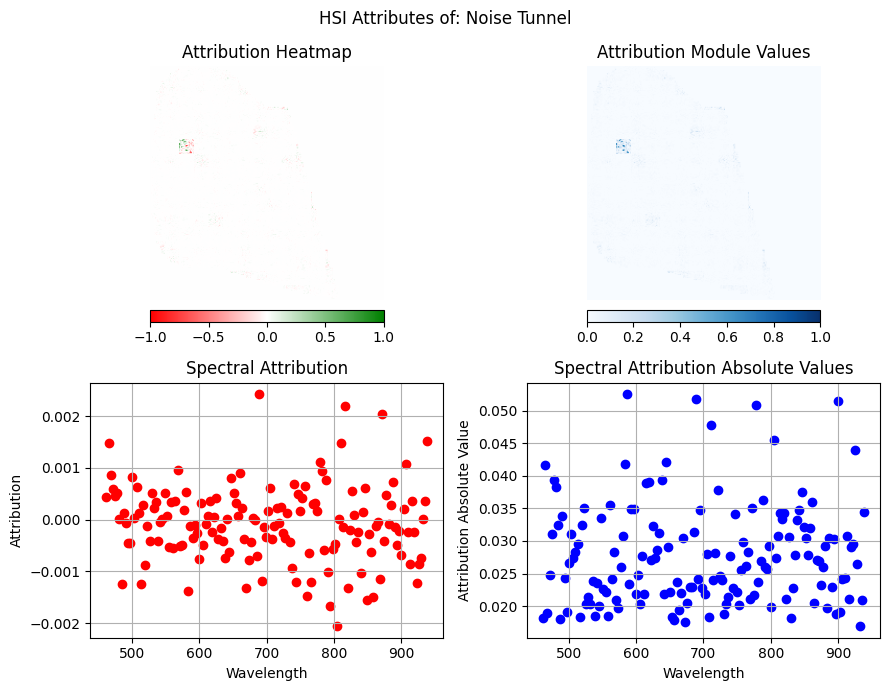

CPU times: user 34.4 s, sys: 4.04 s, total: 38.5 s
Wall time: 7.2 s


In [25]:
%%time
nt_attr = nt_attr.attribute(
    hsi_0,
    target=0,
    n_samples=3,
    method="smoothgrad",
)
mt.visualize.visualize_attributes(nt_attr, use_pyplot=True)

Compared to previous methods and results in the spectral and spatial plots, we observe reduced number of important pixels. This method is specifically designed to eliminate noisy attributions that show high impact regardless of small perturbations, which is particularly evident in the spatial plots where only a few pixels deviate from white. 

While we set the number of perturbed samples (`n_samples`) to `3` in this example for demonstration purposes, this parameter significantly influences the results. Although increasing this value would lead to longer computation times, we encourage users to experiment with higher values and evaluate the resulting attributions to find the optimal balance between accuracy and computational efficiency.

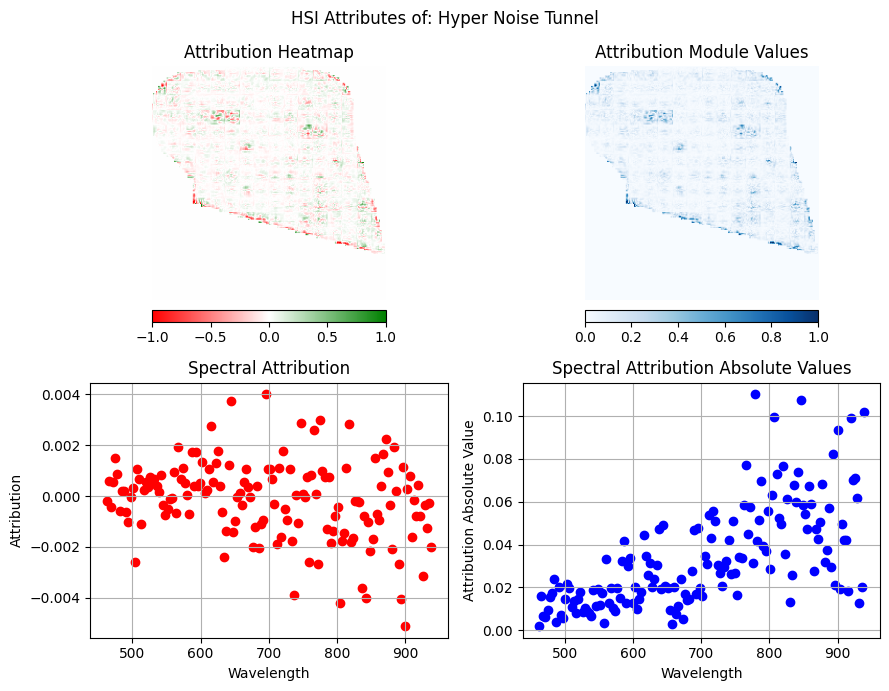

CPU times: user 9min 3s, sys: 1min 18s, total: 10min 21s
Wall time: 2min 4s


In [26]:
%%time
hnt_attr = hnt_attr.attribute(hsi_0, target=0, n_samples=50, baseline=0.0)
mt.visualize.visualize_attributes(hnt_attr, use_pyplot=True)

The HyperNoiseTunnel can produce spatial results as shown above, but as described in the method overview, its spectral analysis capabilities are particularly noteworthy. The analysis reveals that lower wavelength bands have less influence on the method's output, while moving further along the spectral axis, the impact of "removed" pixels increases. Notably, the higher wavelengths show a strong negative influence on the output.

To summarize, while the Noise Tunnel (SmoothGrad) method produces results similar to Input x Gradient, it offers distinct advantages. In spatial visualization, it effectively eliminates low-value variables, highlighting only the most significant patches. This suggests that some regions identified by Input x Gradient might be noise, while these highlighted patches are crucial for prediction. The HyperNoiseTunnel's spectral analysis demonstrates improved clarity and consistency compared to the standard Noise Tunnel, producing patterns more aligned with occlusion-based methods. This similarity to occlusion results indicates that HyperNoiseTunnel provides more reliable and interpretable spectral insights.